In [1]:
# With image data, only few methods work -- FACE, GS, prototype
import numpy as np
import pandas as pd
from sklearn.metrics import pairwise_distances
from sklearn.neural_network import MLPClassifier as NN
import matplotlib.pyplot as plt
from tqdm import tqdm

In [20]:
# Step 1: Find the closest instance (using growing sphere) or any final solution
# Step 2: compute the pixel difference r
# Step 3: binary space partition, and then sort the indices by their distances to the cf instance

def calculate_dist(instance_1, instance_2, norm=2):
    dist = np.linalg.norm((instance_1 - instance_2), ord=norm)
    return dist

def find_closest_cf_instance(factual_point_idx, dataset, predictions, cf_class):
    min_dist = 785
    closest_id = None
    factual_point = np.array(dataset.loc[factual_point_idx])
    for it_count, (idx, instance) in enumerate(dataset.iterrows()):
        prediction = np.argmax(predictions[it_count])
        prediction_prob = np.max(predictions[it_count])
        if prediction == cf_class and prediction_prob>0.8:
            dist = calculate_dist(factual_point, np.array(instance))
            # print(idx, dist)
            if dist < min_dist:
                min_dist = dist
                closest_id = idx
    
    assert closest_id != None, ("No counterfactual found")
    return closest_id, min_dist

def find_closest_instance(anchor_point, dataset):
    min_dist = 785
    closest_id = None
    for idx, instance in dataset.iterrows():
        dist = calculate_dist(anchor_point, instance)
        if dist < min_dist:
            min_dist = dist
            closest_id = idx
        
    assert closest_id != None, ("No factual point found, try increasing epsilon.")
    return closest_id

In [16]:
def find_point(data, start_point_idx, cf_point_idx, epsilon):
    start_point = np.array(data.loc[start_point_idx])
    cf_point = np.array(data.loc[cf_point_idx])

    distances = pairwise_distances(data.values, [start_point, cf_point], metric="l2")
    
    ball_indices = np.where((distances[:,0] <= epsilon) & (distances[:, 1] <= epsilon))[0]
    ball_indices = list(ball_indices)
    if start_point_idx in ball_indices:
        ball_indices.remove(start_point_idx)
    if cf_point_idx in ball_indices:
        ball_indices.remove(cf_point_idx)
    return ball_indices

In [4]:
# Load the dataset
image_size = 28
no_of_different_labels = 10
image_pixels = image_size * image_size
data_path = "../data/raw_data/mnist/mnist_train.csv"

train_data = pd.read_csv(data_path, 
                        delimiter=",", header=None, dtype=np.uint8)
train_imgs = train_data.iloc[:, 1:]/255   # divide by 255 only for model prediction
train_imgs = train_imgs.astype("float32")
# train_imgs = train_data.iloc[:, 1:]
train_labels = np.asarray(train_data.iloc[:, :1][0])

# subsample the original dataset, each digit has 1000 instances rather than 5000-6000
all_indices = []
for digit in np.arange(0,10):
    single_digit_indices = set(np.where(train_labels == digit)[0][:1000])
    all_indices = set(all_indices).union(single_digit_indices)
print("Number of instances:", len(all_indices))

X = train_imgs.iloc[list(all_indices), :]
X.reset_index(drop=True, inplace=True)
y = train_labels[list(all_indices)]

clf = NN(max_iter=5000).fit(X, y)
predictions = clf.predict_proba(X)

Number of instances: 10000


In [21]:
factual_img_idx = 3 # digit 1
cf_class = 9

cf_img_idx, cf_img_dis = find_closest_cf_instance(factual_img_idx, X, predictions, cf_class)
print("Index of counterfactual instance:", cf_img_idx)
print("Distance:", cf_img_dis)

all_path_points = find_point(X, factual_img_idx, cf_img_idx, cf_img_dis)
print(all_path_points)

Index of counterfactual instance: 3510
Distance: 6.379251
[23, 77, 78, 113, 177, 201, 205, 315, 345, 351, 355, 357, 397, 443, 447, 455, 475, 492, 507, 508, 553, 573, 593, 609, 611, 671, 691, 698, 711, 747, 765, 779, 783, 809, 833, 835, 871, 891, 905, 919, 959, 1051, 1085, 1115, 1181, 1211, 1331, 1405, 1425, 1445, 1497, 1527, 1579, 1597, 1601, 1909, 1915, 2039, 2045, 2047, 2166, 2335, 2355, 2393, 2429, 2495, 2497, 2505, 2563, 2583, 2645, 2667, 2695, 2717, 2719, 2807, 2823, 2831, 2843, 2853, 2907, 3331, 3373, 3411, 3427, 3487, 3549, 3561, 3567, 3605, 3729, 3733, 3797, 3831, 3851, 3885, 3889, 3897, 3955, 3956, 4029, 4069, 4105, 4109, 4129, 4137, 4149, 4193, 4225, 4237, 4267, 4351, 4405, 4445, 4553, 4561, 4569, 4623, 4685, 4933, 5051, 5073, 5075, 5107, 5149, 5189, 5221, 5225, 5235, 5237, 5245, 5271, 5301, 5375, 5395, 5425, 5428, 5429, 5439, 5443, 5477, 5483, 5527, 5543, 5571, 5601, 5635, 5643, 5655, 5667, 5675, 5681, 5713, 5731, 5749, 5785, 5859, 5903, 5915, 5933, 5957, 6075, 6083, 6135, 6

In [30]:
# BSP Algorithm
def bsp_partition(data, indices, point1, point2, threshold):
    distances = pairwise_distances(data[indices], [point1, point2], metric='l2')
    partition = np.where((distances[:,0] <= threshold) & (distances[:, 1] <= threshold))[0]
    return indices[partition]

# Recursive BSP function
def recursive_bsp(data, indices, point1, point2, threshold, min_threshold):

    if threshold < min_threshold:
        np.random.seed(42)
        result = np.random.choice(indices, size=1)
        return result
    
    midpoint = (point1 + point2) / 2.0
    threshold = threshold-1
    partition1 = bsp_partition(data, indices, point1, midpoint, threshold)
    partition2 = bsp_partition(data, indices, midpoint, point2, threshold)
    
    if len(partition1) + len(partition2) == 0:
        np.random.seed(42)
        result = np.random.choice(indices, size=1)
        return result
    else:
        if len(partition1) != 0:
            indices1 = recursive_bsp(data, partition1, point1, midpoint, threshold, min_threshold)
        else:   # in this case, partition2 is not empty
            indices1 = []
        
        if len(partition2) != 0:
            indices2 = recursive_bsp(data, partition2, midpoint, point2, threshold, min_threshold)
        else:
            indices2 = []

    return np.concatenate((indices1, indices2))

def sort_path_points(X_np, selected_indices, cf_img):
    cf_point = np.array(cf_img).reshape(1, -1)

    distances = pairwise_distances(X_np[selected_indices], cf_point, metric="l2")
    distances = np.squeeze(distances)
    sorted_indices = np.array(selected_indices)[np.argsort(distances)][::-1]

    return list(sorted_indices)

def ground_vector_path(X_np, factual_img_idx, cf_img_idx, cf_img_dis, all_indices, min_threshold):
    if not all_indices:
        return []
    
    point1 = X_np[factual_img_idx]
    point2 = X_np[cf_img_idx]
    initial_threshold = cf_img_dis

    min_threshold = min_threshold
    all_indices = np.array(all_indices)

    selected_indices = recursive_bsp(X_np, all_indices, point1, point2, initial_threshold, min_threshold)
    selected_indices = list(map(int, set(selected_indices)))
    # print(selected_indices)
    sorted_indices = sort_path_points(X_np, selected_indices, point2)
    sorted_indices.append(cf_img_idx)
    sorted_indices.insert(0, factual_img_idx)
    return sorted_indices


print(factual_img_idx)
print(cf_img_idx)
X_np = X.to_numpy()
selected_path_points = ground_vector_path(X_np, factual_img_idx, cf_img_idx, cf_img_dis, all_indices=all_path_points, min_threshold=2)
print(selected_path_points)

3
3510
[3, 8725, 4149, 5749, 691, 3510]


In [39]:
path_points_list = []
X_np = X.to_numpy()
top_100_one_indices = list(np.where(y==1)[0])[:100]

for idx in tqdm(top_100_one_indices):
    
    factual_img_idx = idx
    cf_img_idx, cf_img_dis = find_closest_cf_instance(factual_img_idx, X, predictions, cf_class)
    # print(factual_img_idx, cf_img_idx)
    all_path_points = find_point(X, factual_img_idx, cf_img_idx, cf_img_dis)
    selected_path_points = ground_vector_path(X_np, factual_img_idx, cf_img_idx, cf_img_dis, all_path_points, min_threshold=2)
    path_points_list.append(selected_path_points)
print(path_points_list)
path_len = [len(path) for path in path_points_list]
print("average path length: {}, std: {}".format(round(np.average(path_len), 2), round(np.std(path_len), 2)))

100%|██████████| 100/100 [00:48<00:00,  2.07it/s]

[[3, 8725, 4149, 5749, 691, 3510], [6, 8660, 6052, 5256, 8382, 7922], [8, 2616, 3900, 7588, 3662], [14, 7650, 8032, 3662], [23, 201, 4105, 611, 7233], [24, 5174, 9717], [40, 7060, 3714, 3662], [59, 3729, 2583, 1579, 691, 3510], [67, 7472, 4708, 2198, 7176, 5390], [70, 7898, 8732, 48], [72, 1942, 3662], [77, 5601, 5395, 3956, 691, 3510], [78, 7533, 7119, 691, 3510], [99, 1081, 1463, 7365], [102, 7020, 6748, 7138, 7588, 3662], [104, 3272, 5336, 8382, 7922], [105, 6613, 1181, 6499, 3956, 3510], [112, 3926, 5530, 3662], [113, 3956, 3510], [124, 7603, 7176, 5390], [128, 3478, 3394, 5708, 7393, 8574, 3662], [134, 3070, 9508], [152, 6775, 4166, 4070, 8602, 3714, 3662], [174, 2906, 8106, 3662], [177, 6247, 1445, 5691, 3355], [184, 5814, 6586, 7588, 3662], [200, 4467, 6116, 746, 2600], [201, 5749, 691, 3510], [205, 779, 8679, 3956, 3510], [208, 6208, 4913, 251, 3703, 3355], [211, 6208, 4913, 5691, 3355], [224, 9214, 8217, 6459], [231, 2894, 2154, 4166, 8602, 5390], [248, 1696, 5256, 6702, 7922]

In [103]:
# from each node in the path, calculate its distance to alternative points
def sum_path_length(path_idx, X):
    path_len_total = 0
    if len(path_idx)> 2:
        for i in range(len(path_idx)-2):
            diff = np.linalg.norm(X.iloc[path_idx[i]] - X.iloc[path_idx[i+1]], ord=2)
            path_len_total += diff
    else:
        path_len_total = np.linalg.norm(X.iloc[path_idx[0]] - X.iloc[path_idx[1]], ord=2)

    return path_len_total


def calculate_shared_perc(path_idx, X, predictions, alter_class):
    alt_class_len_list = []
    for point_idx in path_idx:
        _, cf_img_dis = find_closest_cf_instance(point_idx, X, predictions, alter_class)
        alt_class_len_list.append(cf_img_dis)
    differences = [alt_class_len_list[i + 1] - alt_class_len_list[i] for i in range(len(alt_class_len_list) - 1)]

    stop_point_idx = next((i for i, diff in enumerate(differences) if diff > 0), len(path_idx))

    if stop_point_idx > 0:
        total_path_len = sum_path_length(path_idx, X)
        shared_path_len = sum_path_length(path_idx[:stop_point_idx+1], X)
        shared_perc = shared_path_len/total_path_len
    else:
        shared_perc = 0

    return shared_perc

def calculate_avg_shared_perc(path_idx, X, predictions, alter_classes):
    shared_perc_list = []
    for alt_class in alter_classes:
        result = calculate_shared_perc(path_idx, X, predictions, alt_class)
        shared_perc_list.append(result)
    return np.mean(shared_perc_list)

alter_classes = [2, 3, 4, 5, 6, 7, 8]
grsp_shared_perc_list = []
for path_idx in tqdm(path_points_list):
    shared_perc_one = calculate_avg_shared_perc(path_idx, X, predictions, alter_classes)
    grsp_shared_perc_list.append(shared_perc_one)
print("shared percentage of paths from grsp: {}, std: {}".format(round(np.mean(grsp_shared_perc_list), 2), round(np.std(grsp_shared_perc_list), 2)))


 59%|█████▉    | 59/100 [17:26<14:32, 21.28s/it]

In [ ]:
def calculate_weighted_distance(v0, v1, penalty_term = 1.1):
    diff = np.subtract(v0, v1)
    reweight_vector = np.where(diff>=0, 1, -penalty_term)
    weighted_diff = np.linalg.norm(diff*reweight_vector)
    return weighted_diff

def sum_path_weighted_length(path_idx, X):
    path_len_total = 0
    if len(path_idx)> 2:
        for i in range(len(path_idx)-2):
            diff = calculate_weighted_distance(X.loc[path_idx[i+1]], X.loc[path_idx[i]])
            path_len_total += diff
    else:
        path_len_total = calculate_weighted_distance(X.loc[path_idx[1]], X.loc[path_idx[0]])

    return path_len_total

grsp_dist_list = []
for path_idx in tqdm(path_points_list):
    dist = sum_path_weighted_length(path_idx, X)
    grsp_dist_list.append(dist)
print("average distance of shortest path: {}, std: {} ".format(round(np.mean(grsp_dist_list), 2), round(np.std(grsp_dist_list), 2)))

In [8]:
def plot_digit(X, img_idx):
    fig, ax = plt.subplots(figsize=(4, 4))

    image = np.array(X.iloc[img_idx, :])
    ax.set_axis_off()
    ax.imshow(image.reshape(28, 28), cmap=plt.cm.gray_r, interpolation="nearest")


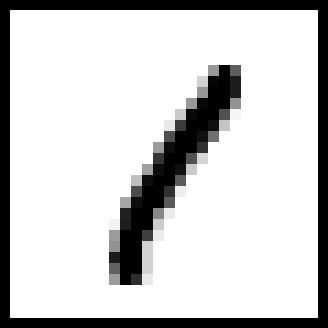

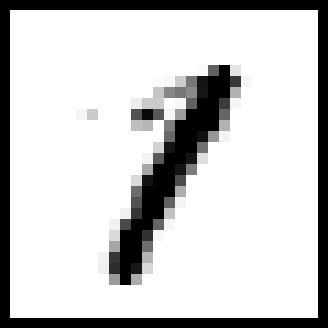

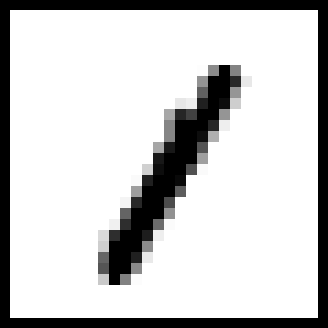

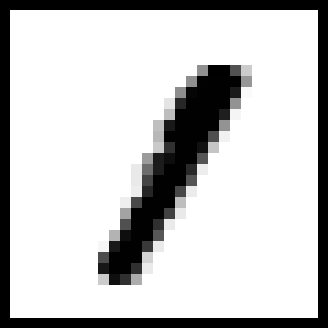

In [29]:
# plot_digit(X, 3510)
# plot_digit(X, 720)
for id in [8725, 4149, 5749, 691]:
    plot_digit(X, id)